# Optimization - Predicted Angles vs. True Angles

[Michaël Defferrard](https://deff.ch), EPFL LTS2  
[Laurène Donati](https://people.epfl.ch/laurene.donati), EPFL BIG  
[Jelena Banjac](https://people.epfl.ch/jelena.banjac), EPFL MSc in Data Science

In [1]:
from time import time
import h5py
import os
from sklearn.neighbors import NearestNeighbors

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow_graphics.util import asserts
from tensorflow_graphics.math import vector
from tensorflow_graphics.util import safe_ops
from tensorflow_graphics.util import shape
from tensorflow_graphics.geometry.transformation import quaternion, euler

---

## Data

In [2]:
n_samples = 5000

In [3]:
# location of *.h5 files
data_dir = "../data"

# half coverage (AngCoverage=0.5)
projections_filename = "ProjectionsAngles_ProjNber5000_AngCoverage0.5_AngShift1.57"

# load structures
data = h5py.File(os.path.join(data_dir, f"{projections_filename}.h5"), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (136, 136) pixels
5000 sets of 3 ground truth angles of corresponding projection images


##### Angles

###### Predicted Angles 

In [4]:
low_ang = np.pi/2
high_ang = 2*np.pi - np.pi/2

euler = np.random.uniform(low=[low_ang, low_ang, low_ang], 
                          high=[high_ang, high_ang, high_ang],
                          size=(n_samples, 3))

# angles_predicted = [tf.Variable(e, constraint=lambda x: tf.clip_by_value(x, low_ang, high_ang)) for e in euler]
angles_predicted = [tf.Variable(e) for e in euler]
print(f"Angles predicted: (min, max) = ({tf.reduce_min(angles_predicted):.4f}, {tf.reduce_max(angles_predicted):.4f})")

angles_predicted = np.array(angles_predicted)
angles_predicted.shape

Angles predicted: (min, max) = (1.5712, 4.7124)


(5000,)

###### True Angles 

In [5]:
angles_true = np.reshape(data["Angles"], (data["Angles"].shape[0], -1))
print(f"Angles true: (min, max) = ({np.min(angles_true):.4f}, {np.max(angles_true):.4f})")

angles_true = np.array(angles_true)
angles_true.shape

Angles true: (min, max) = (1.5713, 4.7120)


(5000, 3)

##### Projections

In [6]:
# projections = np.reshape(data["Projections"], (data["Projections"].shape[0], -1))
# projections.shape

(5000, 18496)

In [7]:
# n_pixels = projections.shape[1]

---

## Distances

##### Angle Distances

In [8]:
def d_q(q1, q2):
     with (tf.compat.v1.name_scope(None, "quaternion_relative_angle",
                                 [q1, q2])):
        q1 = tf.convert_to_tensor(value=q1)
        q2 = tf.convert_to_tensor(value=q2)
      
        shape.check_static(
            tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4))
        shape.check_static(
            tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))

        q1 = quaternion.normalize(q1)
        q2 = quaternion.normalize(q2)
        
        dot_product = vector.dot(q1, q2, keepdims=False)
        
        # Ensure dot product is in range [-1. 1].
        const = 1.8 #4.0 #.63
        eps_dot_prod = const * asserts.select_eps_for_addition(dot_product.dtype)
        dot_product = safe_ops.safe_shrink(
            dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

        return 2.0 * tf.acos(tf.abs(dot_product))
    
assert tf.reduce_mean(d_q(quaternion.from_euler(angles_true[0:3]), quaternion.from_euler(angles_true[0:3]))) < 1e-7
assert (d_q(quaternion.from_euler([np.pi/2]*3), quaternion.from_euler([2*np.pi-np.pi/2]*3))-np.pi) < 1e-7

##### Projection Distance

In [9]:
# def d_p(p1, p2):
#     # (learned) distance between two images.
#     # for now, Euclid dist
#     p1 = tf.convert_to_tensor(value=p1, dtype=np.float32)
#     p2 = tf.convert_to_tensor(value=p2, dtype=np.float32)

#     if len(p1.shape) > 1:
#         dist = tf.norm(p1-p2, ord='euclidean', axis=1, keepdims=True)
#     else:
#         dist = tf.norm(p1-p2, ord='euclidean')

#     return dist

# assert tf.reduce_mean(d_p(projections[0:3], projections[0:3])) < 1e-7

---

## Loss and gradient

Our goal is to then optimize
$$ \operatorname*{arg\,min}_{\{\hat{Q}_i\}_{i=1}^n} \sum_{i,j} \left| d_p(p_i, p_j) - d_Q(\hat{Q}_i, \hat{Q}_j) \right|^2, $$
where $p_i$ is a projected image and $d_p$ is a (learned) distance between two images.

In [10]:
def loss(a1_predicted, a2_predicted, distance_target):
    q1_predicted = quaternion.from_euler(a1_predicted)
    q2_predicted = quaternion.from_euler(a2_predicted)
    
    q1 = quaternion.normalize(q1_predicted)
    q2 = quaternion.normalize(q2_predicted)
    
    distance = d_q(q1, q2)
    
#     distance        = normalize_quaternion_distance(distance)
#     distance_target = normalize_quaternion_distance(distance_target)
    
    # The mean doesn't depend on the batch size.
    return tf.reduce_mean((distance - distance_target)**2)

In [11]:
def gradient(a1_predicted, a2_predicted, distance_target):
    with tf.GradientTape() as tape:
        loss_value = loss(a1_predicted, a2_predicted, distance_target)
        gradient = tape.gradient(loss_value, a1_predicted + a2_predicted)
        
    return loss_value, gradient

---

## Optimization loop (angles-true & angles-predict)

step 2000/20000 (169s): loss = 7.64e-01
step 4000/20000 (327s): loss = 1.54e-01
step 6000/20000 (485s): loss = 3.22e-03
step 8000/20000 (643s): loss = 9.11e-04
step 10000/20000 (807s): loss = 2.33e-04
step 12000/20000 (966s): loss = 2.37e-04
step 14000/20000 (1125s): loss = 1.88e-04
step 16000/20000 (1285s): loss = 1.22e-04
step 18000/20000 (1447s): loss = 5.43e-05
step 20000/20000 (1601s): loss = 1.19e-04


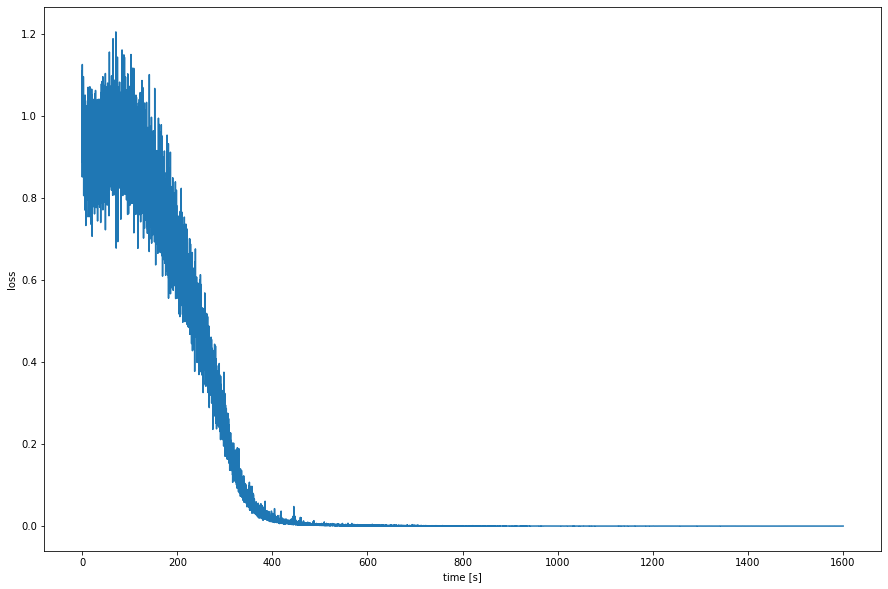

In [12]:
steps=20000
batch_size=256

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

losses = np.empty(steps)
time_start = time()

for step in range(1, steps+1):

    # Sample some pairs.
    idx1 = list(np.random.randint(0, n_samples, batch_size))
    idx2 = list(np.random.randint(0, n_samples, batch_size))
    a1 = [angles_predicted[i] for i in idx1]
    a2 = [angles_predicted[i] for i in idx2]

    # Compute distances between projections
    a1_true = [angles_true[i] for i in idx1]
    a2_true = [angles_true[i] for i in idx2]
    q1_true = quaternion.from_euler(a1_true)
    q2_true = quaternion.from_euler(a2_true)
    q1_true = quaternion.normalize(q1_true)
    q2_true = quaternion.normalize(q2_true)

    distance_target = d_q(q1_true, q2_true)

    # Optimize by gradient descent.
    losses[step-1], gradients = gradient(a1, a2, distance_target)
    optimizer.apply_gradients(zip(gradients, a1 + a2))

    # Periodically report progress.
    if ((step % (steps//10)) == 0) or (step == steps):
        time_elapsed = time() - time_start
        print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

# Plot convergence.
plt.figure(figsize=(15,10))
plt.plot(np.linspace(0, time()-time_start, steps), losses)
plt.xlabel('time [s]')
plt.ylabel('loss');